**Model Source:**<br />
https://github.com/kuangliu/pytorch-cifar/blob/49b7aa97b0c12fe0d4054e670403a16b6b834ddd/models/dla_simple.py

# Setup Variables

MNIST, FashionMNIST, GTSRB, Cifar10

In [1]:
DATASET = 'MNIST'
SEED = 42
CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

In [3]:
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

# Libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import json
from fastprogress import progress_bar, master_bar

import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchinfo import summary


cudnn.benchmark = True
torch.set_float32_matmul_precision('high')

In [13]:
from utilities.utils import *
from utilities.pathManager import fetchPaths

In [18]:
from models.mnist_model import MNIST_Model
from models.fashionmnist_model import FashionMNIST_CNN
from models.gtsrb_model import GTSRB_CNN
from models.cifar10_dla import Cifar10_DLA

from models.transformers import transformers

models = {
    'mnist': MNIST_Model,
    'fashionmnist': FashionMNIST_CNN,
    'gtsrb': GTSRB_CNN,
    'cifar10': Cifar10_DLA    
}

model_ = models[DATASET.lower()]
transformer = transformers[DATASET.lower()]

# Paths

In [7]:
paths = fetchPaths(base, DATASET, '', False)

path_data = paths['data']
path_model = paths['model']
path_saved_model = paths['saved_models']
path_bdd = paths['bdd']
path_lhl_raw = paths['lhl_raw']
path_lhl_pca = paths['lhl_pca']

configs = load_json(paths['configuration'])
bdd_configs = configs['configuration']
model_setup = configs['model_setup']
model_config = configs['model_config']

# GPU Device & Seed

In [11]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [12]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

# Load / Split / DataLoader

In [20]:
feature_names = get_labels(DATASET)

train_data = get_dataset(DATASET, path_data, train=True, transform=transformer['train'])
test_data = get_dataset(DATASET, path_data, train=False, transform=transformer['test'])
len(train_data), len(test_data)

(60000, 10000)

In [21]:
trainloader = get_dataLoader(train_data, model_config['batch_size'], True)
testloader = get_dataLoader(test_data, model_config['batch_size'], False)

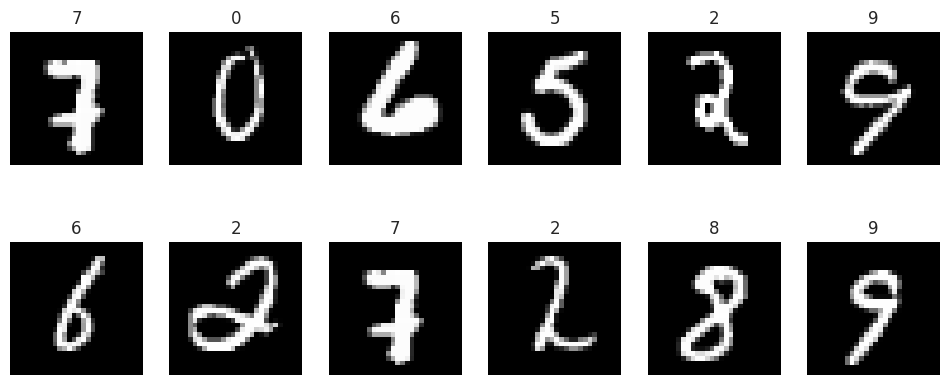

In [22]:
show_images_loader(trainloader, feature_names=feature_names)

# Helper Functions

In [23]:
def create_model(lhl):  
    
    # model
    model_setup['last_hidden_neurons'] = lhl
    
    # torch 2.0 compile and parallel data training
    model = model_(**model_setup).to(device)
    model = torch.compile(model)
    nn.DataParallel(model, device_ids=[CUDA])
    
    # loss function
    loss_function = nn.CrossEntropyLoss()
    
    # optimizer and scheduler
    optimizer = torch.optim.SGD(model.parameters(), lr=model_config['lr'], momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=model_config['epochs'])
    
    # model prefix and create folders
    POSTFIX = f"{type(optimizer).__name__}-{model_config['batch_size']}-{lhl}"
    
    return POSTFIX, model, loss_function, optimizer, scheduler

In [24]:
def create_folders(postfix):
    model_name = f'{DATASET}_{postfix}'
    paths = fetchPaths(base, DATASET, postfix)
    path_saved_model = paths['saved_models']
    path_lhl_raw = paths['lhl_raw']
    path_lhl_pca = paths['lhl_pca']
    
    return model_name, path_saved_model, path_lhl_raw, path_lhl_pca

In [25]:
def start_training_testing(model, loss_function, optimizer, scheduler):
    # training testing attributes
    kwargs = {
        'model': model,
        'loss_function': loss_function,
        'optimizer': optimizer,
        'lr_scheduler': scheduler,
        'map_classes': None,
        'skip_classes': None,
        'device': device,
        'model_path': path_saved_model / f"{DATASET}_{POSTFIX}.pth.tar",
        'trainloader': trainloader,
        'testloader': testloader,
        'config': model_config
    }

    # run training testing
    return run_training_testing(**kwargs)

## Run Training

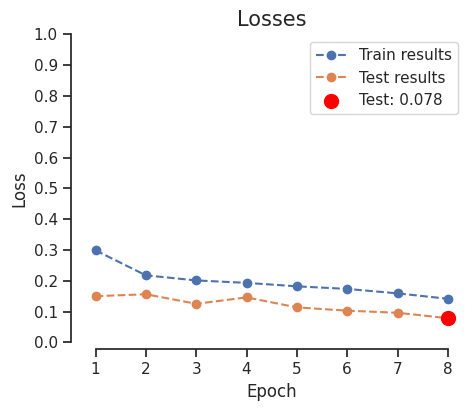

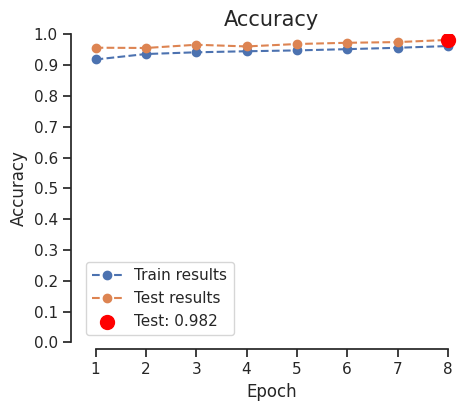

NameError: name 'get_last_hidden_layer' is not defined

In [27]:
for lhl in bdd_configs['lhl_neurons']:

    POSTFIX, model, loss_function, optimizer, scheduler = create_model(lhl)
    model_name, path_saved_model, path_lhl_raw, path_lhl_pca = create_folders(POSTFIX)
    
    train_losses, test_losses, train_accs, test_accs, test_loss, test_acc, confusion_matrix_test, best_model_name = \
    start_training_testing(model, loss_function, optimizer, scheduler)
    
    # load best model
    load_checkpoint(model, best_model_name)
    
    # normalize and save matrix
    confusion_matrix_test_norm = normalize_confusion_matrix(confusion_matrix_test)
    save_confusion_matrix(confusion_matrix_test_norm, path_saved_model, model_name, 'test')
    
    # export last hidden layer data
    export_last_hidden_layer(trainloader, model, device, lhl, None, path_lhl_raw, model_name, 'train')
    export_last_hidden_layer(testloader, model, device, lhl, None, path_lhl_raw, model_name, 'test')
    
    # export pca
    
    
    
    break

In [28]:
# export last hidden layer data
export_last_hidden_layer(trainloader, model, device, lhl, None, path_lhl_raw, model_name, 'train')
export_last_hidden_layer(testloader, model, device, lhl, None, path_lhl_raw, model_name, 'test')